# Hybrid AI for Clinical Prediction: Diabetes Classification Research Notebook

This Jupyter Notebook comprehensively implements the research methodology outlined in the paper "Hybrid AI for Clinical Prediction: An Explainable and Robust Framework for Diabetes Classification."

### Reproducibility Checklist

This notebook aims for full reproducibility of the research findings. To ensure successful execution and replication of results, please follow this checklist:

* **Environment Setup:**
    * Ensure Python 3.8+ is installed.
    * Run the `!pip install` command in Section 0.1 to install all required libraries (e.g., `pandas`, `numpy`, `scikit-learn`, `shap`, `aif360`, `google-generativeai`, `tqdm`, `umap-learn`).
* **Data Acquisition:**
    * Place `pima-indians-diabetes.csv` in the `/content/` directory.
    * Place `diabetes_012_health_indicators_BRFSS2015.csv`, `diabetes_binary_5050split_health_indicators_BRFSS2015.csv`, and `diabetes_binary_health_indicators_BRFSS2015.csv` in the `/content/` directory. (The notebook includes dummy data fallback if files are not found, but for full reproducibility, provide the actual data).
* **API Key Configuration (for actual LLM calls):**
    * If you wish to run actual LLM feature generation (beyond simulation), obtain a Gemini API key from Google AI Studio.
    * Set the `GEMINI_API_KEY` as an environment variable (recommended) or directly replace the placeholder in the `gemini_predict_limited` function.
* **Execution Flow:**
    * Run all cells sequentially from top to bottom.
    * Restart the kernel and clear all outputs before a fresh run to ensure a clean state.
* **Output Verification:**
    * Check the printed metrics and generated plots in the `figures/` directory for consistency with the paper's reported results.
    * Verify the SHAP plots and fairness metrics for expected insights.

## 0. ⚙️ Setup and Utility Functions

This section handles the installation of necessary libraries, defines data mappings for LLM prompt generation, imports all required Python modules, and sets up utility functions used throughout the notebook for data processing, model evaluation, and visualization.

### 0.1 Installations

Install all necessary Python libraries. This ensures that the environment has all the required dependencies for data manipulation, machine learning, plotting, LLM interaction, and fairness analysis.

**Note**: If you are running this in a new environment, you might need to uncomment and run this cell.

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn sentence-transformers tqdm google-generativeai shap scipy umap-learn aif360


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

### 0.2 Data Mappings for LLM Prompt Generation

These dictionaries are crucial for converting numerical and categorical features from the raw datasets into human-readable narratives. These narratives will then be used as input prompts for the Large Language Model (LLM) to generate new, high-level features.

In [ ]:
binary_narratives = {
    "highchol": {1: "has high cholesterol", 0: "does not have high cholesterol"},
    "stroke": {1: "has had a stroke", 0: "has not had a stroke"},
    "diffwalk": {1: "has difficulty walking", 0: "can walk without difficulty"},
    "highbp": {1: "has high blood pressure", 0: "does not have high blood pressure"},
    "cholcheck": {1: "has had cholesterol checked", 0: "has not had cholesterol checked"},
    "smoker": {1: "is a smoker", 0: "is not a smoker"},
    "physactivity": {1: "does physical activity", 0: "does not do physical activity"},
    "fruits": {1: "eats fruits", 0: "does not eat fruits"},
    "veggies": {1: "eats vegetables", 0: "does not eat vegetables"},
    "hvyalcoholconsump": {1: "consumes heavy alcohol", 0: "does not consume heavy alcohol"},
    "anyhealthcare": {1: "has healthcare access", 0: "does not have healthcare access"},
    "nodocbccost": {1: "avoided doctor due to cost", 0: "did not avoid doctor due to cost"},
    "sex": {1: "is male", 0: "is female"}
}

age_map = {
    1: "18-24 years old", 2: "25-29 years old", 3: "30-34 years old",
    4: "35-39 years old", 5: "40-44 years old", 6: "45-49 years old",
    7: "50-54 years old", 8: "55-59 years old", 9: "60-64 years old",
    10: "65 years or older"
}

education_map = {
    1: "no schooling completed", 2: "completed elementary school",
    3: "not finished high school", 4: "completed high school",
    5: "attended some college but didn't complete it", 6: "graduated college",
    7: "a postgraduate education"
}

income_map = {
    1: "an income less than $10,000", 2: "an income $10,000-$14,999",
    3: "an income between $15,000 and $19,999", 4: "an income between $20,000 and $24,999",
    5: "an income between $25,000 and $34,999", 6: "an income between $35,000 and $49,999",
    7: "an income between $50,000 and $74,999", 8: "an income between $75,000 and $99,999",
    9: "an income between $100,000 and $149,999", 10: "an income above $150,000"
}

### 0.3 Imports

Import all necessary Python libraries for data manipulation, machine learning, plotting, and LLM interaction. This also creates a directory for figures to store visualizations.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.stats import ttest_rel, uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from umap import UMAP
import shap
from xgboost import XGBClassifier
import joblib
import time
import google.generativeai as genai
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from google.colab import userdata

FIGURES_DIR = 'figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### 0.4 Function Definitions

This subsection defines several utility functions that streamline the research process:
- `evaluate_and_print_metrics`: Calculates and displays key classification metrics, including accuracy, recall, F1-score, and a confusion matrix.
- `clean_data`: Handles missing values in the dataset by replacing specific zero values with NaNs and then imputing them with the median.
- `plot_roc_curve`: Generates and optionally saves the Receiver Operating Characteristic (ROC) curve and calculates the Area Under the Curve (AUC).
- `generate_prompts`: Converts structured patient data into natural language prompts suitable for LLM input.
- `gemini_predict_limited`: (Simulated) Demonstrates how to interact with the Gemini API for predictions, including rate limiting and error handling. For this notebook, it's adapted to simulate LLM feature generation due to practical API call limitations for full datasets.

In [ ]:
def evaluate_and_print_metrics(model_name, y_true, y_pred, phase="", print_confusion_matrix=True, save_path=None):
    """
    Calculates and prints key classification metrics and optionally displays/saves a confusion matrix.
    """
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    print(f"-- {model_name} {phase} Metrics --")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_true, y_pred)}")

    if print_confusion_matrix:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',\
                    xticklabels=['Pred Neg','Pred Pos'], yticklabels=['True Neg','True Pos'])
        plt.title(f'{model_name} {phase} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Saved confusion matrix to {save_path}")
        plt.show()
    return {'accuracy': accuracy, 'recall': recall, 'f1_score': f1, 'report': report}

def clean_data(df, feats):
    df = df.copy()
    for col in feats:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            legitimate_zeros = [
                'pregnancies', 'cholcheck', 'smoker', 'stroke', 'heartdiseaseorattack',
                'physactivity', 'fruits', 'veggies', 'hvyalcoholconsump', 'anyhealthcare',
                'nodocbccost', 'diffwalk', 'sex', 'diabetes_012'
            ]
            if col not in legitimate_zeros:
                df[col] = df[col].replace(0, np.nan)
            df[col] = df[col].fillna(df[col].median())
        else:
            print(f"⚠️ Skipping non-numeric or missing feature: {col}")
    return df

def plot_roc_curve(y_true, y_scores, model_name="Model", ax=None, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    if ax:
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {model_name}')
        ax.legend(loc="lower right")
    if save_path and ax is None:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        print(f"Saved ROC curve to {save_path}")
    return roc_auc

def generate_prompts(df):

    prompts = []
    for _, row in df.iterrows():
        parts = []

        # 1. Demographic background
        if 'source' in row and pd.notna(row['source']):
            if row['source'] == 'CDC':
                parts.append("is of American background")
            elif row['source'] == 'PIMA':
                parts.append("is of Native American (Pima) background")

        # 2. Age
        if 'age' in row and pd.notna(row['age']):
            age_val = int(row['age'])
            age_str = age_map.get(age_val, f"age category {age_val}")
            parts.append(f"is {age_str}")

        # 3. Sex
        if 'sex' in row and row['sex'] in binary_narratives['sex']:
            parts.append(binary_narratives['sex'][row['sex']])

        # 4. Education
        if 'education' in row and pd.notna(row['education']):
            edu_val = int(row['education'])
            edu_str = education_map.get(edu_val, f"education level {edu_val}")
            parts.append(f"has {edu_str}")

        # 5. Income
        if 'income' in row and pd.notna(row['income']):
            income_val = int(row['income'])
            income_str = income_map.get(income_val, f"income level {income_val}")
            parts.append(f"has {income_str}")

        # 6. Binary health flags
        for col in binary_narratives:
            if col in row and pd.notna(row[col]) and col != 'sex':
                parts.append(binary_narratives[col].get(row[col], f"{col} {row[col]}"))

        # 7. Numerical features (exclude known categorical/binary columns and label)
        skip_cols = set(['label', 'source', 'age', 'sex', 'education', 'income', 'diabetes_012']).union(binary_narratives.keys())
        for col, val in row.items():
            if col in skip_cols:
                continue
            if pd.isna(val):
                continue
            try:
                val_float = float(val)
                sval = f"{int(val_float)}" if val_float.is_integer() else f"{val_float:.1f}"
            except:
                sval = str(val)
            parts.append(f"{col.replace('_', ' ')} {sval}")

        prompt = "Patient who " + ", ".join(parts) + "."
        prompts.append(prompt)
    return prompts

def gemini_predict_limited(df, model_name='gemini-2.0-flash', limit=400, save_path='gemini_preds.csv'):
    try:
        api_key = os.environ.get("GEMINI_API_KEY", "YOUR_GEMINI_API_KEY_HERE")
        if api_key == "YOUR_GEMINI_API_KEY_HERE":
            print("Warning: GEMINI_API_KEY environment variable not set. Using placeholder. Gemini API calls will likely fail.")
            return pd.DataFrame()
        genai.configure(api_key=api_key)
    except Exception as e:
        print(f"Error configuring Gemini API: {e}. Please ensure your API key is set correctly.")
        print("Skipping Gemini prediction as API key is not configured.")
        return pd.DataFrame()

    model = genai.GenerativeModel(model_name)

    if df.empty:
        print("Provided DataFrame is empty for Gemini prediction.")
        return pd.DataFrame()

    df_done = pd.DataFrame(columns=['index', 'prompt', 'label', 'prediction'])
    if os.path.exists(save_path):
        try:
            df_done = pd.read_csv(save_path)
            print(f"Loaded {len(df_done)} previous predictions from {save_path}.")
        except pd.errors.EmptyDataError:
            print(f"Existing file {save_path} is empty. Starting fresh.")
        except Exception as e:
            print(f"Error loading existing predictions from {save_path}: {e}. Starting fresh.")

    done_indices = set(df_done['index'].astype(int))
    prompts = generate_prompts(df)
    call_count = 0
    rows_to_append = []

    print(f"Starting Gemini predictions. Limit: {limit} calls.")
    for i, row in enumerate(tqdm(df.itertuples(index=False), total=len(df))):
        if call_count >= limit:
            print(f"Reached API call limit of {limit}. Stopping.")
            break
        if i in done_indices:
            continue

        prompt = prompts[i]
        label = int(getattr(row, 'label', 0))

        try:
            result = model.generate_content([
                "You are a medical assistant AI that predicts diabetes risk based on patient information. Use the demographics (such as age, gender, and background) along with health indicators to decide.",
                "Your task is to reply with either 0 (doesn't have diabetes) or 1 (might have diabetes). Respond with a single digit only.",
                prompt
            ])

            if result.text.strip():
                try:
                    pred = int(result.text.strip())
                    if pred not in [0, 1]:
                        raise ValueError("Invalid prediction format")
                except ValueError:
                    print(f"Warning: Gemini returned non-binary prediction '{result.text.strip()}' for index {i}. Attempting conversion.")
                    try:
                        pred = int(float(result.text.strip()) > 0.5)
                    except ValueError:
                        print(f"Could not parse prediction for index {i}. Defaulting to 0.")
                        pred = 0
            else:
                print(f"Warning: Empty response from Gemini for index {i}. Defaulting to 0.")
                pred = 0

            rows_to_append.append({'index': i, 'prompt': prompt, 'label': label, 'prediction': pred})
            call_count += 1

            if len(rows_to_append) >= 50:
                append_mode = os.path.isfile(save_path) and os.path.getsize(save_path) > 0
                pd.DataFrame(rows_to_append).to_csv(save_path, mode='a', header=not append_mode, index=False)
                rows_to_append.clear()
                df_done = pd.read_csv(save_path)
                done_indices = set(df_done['index'].astype(int))

            time.sleep(2.5)

        except Exception as e:
            print(f"⚠️ Error on index {i}: {str(e)}")
            if "429" in str(e) or "quota" in str(e).lower() or "timeout" in str(e).lower():
                print("🚨 Quota exceeded or timeout detected. Stopping further API calls.")
                break
            continue

    print("Finished or reached API limit for Gemini predictions.")
    if rows_to_append:
        append_mode = os.path.isfile(save_path) and os.path.getsize(save_path) > 0
        pd.DataFrame(rows_to_append).to_csv(save_path, mode='a', header=not append_mode, index=False)

    if os.path.exists(save_path):
        df_final = pd.read_csv(save_path)
    else:
        df_final = pd.DataFrame()

    if df_final.empty or 'prediction' not in df_final or df_final['prediction'].dropna().empty:
        print("No valid Gemini predictions available to evaluate.")
        return df_final

    y_true_gemini = df_final['label'].astype(int)
    y_pred_gemini = df_final['prediction'].astype(int)
    evaluate_and_print_metrics("Gemini", y_true_gemini, y_pred_gemini, phase=f"on {len(df_final)} prompts",
                               print_confusion_matrix=True, save_path=os.path.join(FIGURES_DIR, 'gemini_confusion_matrix.png'))
    return df_final

def generate_simulated_llm_features(df_original):
    df = df_original.copy()

    df['cardiovascular_risk_llm'] = ((df['highbp'] == 1) | (df['highchol'] == 1) | \
                                     (df['stroke'] == 1) | (df['heartdiseaseorattack'] == 1)).astype(int)

    df['lifestyle_health_score_llm'] = (df['physactivity'] + df['fruits'] + df['veggies'] - \
                                        df['hvyalcoholconsump'] - df['smoker'])
    df['lifestyle_health_score_llm'] = df['lifestyle_health_score_llm'].rank(pct=True)

    df['access_care_concern_llm'] = ((df['nodocbccost'] == 1) | (df['diffwalk'] == 1) | \
                                     (df['anyhealthcare'] == 0)).astype(int)

    print("Generated simulated LLM features:", [col for col in df.columns if '_llm' in col])
    return df[[col for col in df.columns if '_llm' in col]]

## 1. 🧹 Data Cleaning & Processing

This section handles the loading, cleaning, and initial processing of the PIMA Indians Diabetes Database and CDC's BRFSS2015 datasets. It ensures data consistency and prepares the features for model training, including the generation of simulated LLM-derived features.

### 1.1 Load PIMA CSV

Loads the PIMA Indians Diabetes dataset from the specified path. If the file is not found, a dummy DataFrame is created to allow the notebook to run without interruption, though results will not be meaningful without the actual data.

In [ ]:
pima_path = '/content/pima-indians-diabetes.csv'
if not os.path.exists(pima_path):
    print(f"Warning: {pima_path} not found. Creating a dummy PIMA DataFrame for demonstration.")
    df_pima = pd.DataFrame(np.random.rand(100, 9), columns=['pregnancies','glucose','bloodpressure','skinthickness','insulin','bmi','pedigree','age','class'])
    df_pima['class'] = np.random.randint(0, 2, 100)
else:
    df_pima = pd.read_csv(pima_path)
df_pima['source'] = 'PIMA'

### 1.2 Load CDC files

Loads and concatenates the CDC diabetes health indicators datasets. Similar to the PIMA dataset, dummy DataFrames are created if the files are not found, ensuring the notebook's executability.

In [ ]:
cdc_paths = [
    '/content/diabetes_012_health_indicators_BRFSS2015.csv',
    '/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
    '/content/diabetes_binary_health_indicators_BRFSS2015.csv'
]

df_cdc_list = []
for path in cdc_paths:
    if not os.path.exists(path):
        print(f"Warning: {path} not found. Skipping this CDC file and creating dummy data if no other CDC files are found.")
    else:
        df_cdc_list.append(pd.read_csv(path))

if not df_cdc_list:
    print("No CDC files found. Creating a dummy CDC DataFrame for demonstration.")
    df_cdc = pd.DataFrame(np.random.rand(100, 22), columns=[
        'diabetes_012', 'highbp', 'highchol', 'cholcheck', 'bmi', 'smoker', 'stroke',
        'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies', 'hvyalcoholconsump',
        'anyhealthcare', 'nodocbccost', 'genhlth', 'menthlth', 'physhlth', 'diffwalk',
        'sex', 'age', 'education', 'income'
    ])
    df_cdc['diabetes_012'] = np.random.randint(0, 3, 100)
    df_cdc['diabetes_binary'] = df_cdc['diabetes_012'].apply(lambda x: 1 if x == 2 else 0)
else:
    df_cdc = pd.concat(df_cdc_list, axis=0, ignore_index=True)
df_cdc['source'] = 'CDC'

### 1.3 Clean Column Names

Standardizes column names across both datasets to lowercase and replaces spaces with underscores. This ensures consistency and simplifies feature referencing.

In [ ]:
for df in [df_pima, df_cdc]:
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print("📘 PIMA columns after clean:", df_pima.columns.tolist())
print("📘 CDC columns after clean:", df_cdc.columns.tolist())

📘 PIMA columns after clean: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'pedigree', 'age', 'class', 'source']
📘 CDC columns after clean: ['diabetes_012', 'highbp', 'highchol', 'cholcheck', 'bmi', 'smoker', 'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies', 'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth', 'menthlth', 'physhlth', 'diffwalk', 'sex', 'age', 'education', 'income', 'diabetes_binary', 'source']


### 1.4 Identify PIMA Label Column

Identifies the target variable (label) column for the PIMA dataset. It checks for common naming conventions (`outcome`, `class`, `diabetes`) to ensure the correct column is selected.

In [ ]:
if 'outcome' in df_pima.columns:
    label_pima = 'outcome'
elif 'class' in df_pima.columns:
    label_pima = 'class'
elif 'diabetes' in df_pima.columns:
    label_pima = 'diabetes'
else:
    raise ValueError("❌ No known label column ('outcome', 'class', 'diabetes') found in PIMA dataset.")

### 1.5 Identify CDC Label Column

Identifies and standardizes the target variable column for the CDC dataset. It handles cases where the diabetes status might be represented by `diabetes_012` (0=no diabetes, 1=prediabetes, 2=diabetes) by converting it to a binary `diabetes_binary` (0=no diabetes/prediabetes, 1=diabetes).

In [ ]:
if 'diabetes_binary' in df_cdc.columns:
    label_cdc = 'diabetes_binary'
elif 'diabetes_012' in df_cdc.columns:
    df_cdc['diabetes_binary'] = df_cdc['diabetes_012'].apply(lambda x: 1 if x == 2 else 0)
    label_cdc = 'diabetes_binary'
else:
    raise ValueError("❌ Could not identify a diabetes label in CDC dataset.")

print(f"✅ PIMA label: {label_pima}")
print(f"✅ CDC label: {label_cdc}")

✅ PIMA label: class
✅ CDC label: diabetes_binary


### 1.6 Feature Selection

Selects the relevant features for each dataset based on the paper's methodology. For PIMA, a predefined list of features is used. For CDC, all numerical columns are selected, excluding the label and any intermediate diabetes status columns.

In [ ]:
expected_feats_pima = ['pregnancies','glucose','bloodpressure','skinthickness','insulin','bmi','pedigree','age']
expected_feats_pima = [f for f in expected_feats_pima if f in df_pima.columns] # Ensure features exist
print("✅ Final features for PIMA:", expected_feats_pima)

exclude_cdc = [label_cdc, 'diabetes_012']
numeric_cols_cdc = df_cdc.select_dtypes(include=np.number).columns
expected_feats_cdc = [f for f in numeric_cols_cdc if f not in exclude_cdc]
print("✅ Final features for CDC:", expected_feats_cdc)

✅ Final features for PIMA: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'pedigree', 'age']
✅ Final features for CDC: ['highbp', 'highchol', 'cholcheck', 'bmi', 'smoker', 'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies', 'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth', 'menthlth', 'physhlth', 'diffwalk', 'sex', 'age', 'education', 'income']


### 1.7 Standardize and Combine Datasets

This step prepares the PIMA and CDC datasets for concatenation. It selects the identified features and label, renames the label column to a common name (`label`), and aligns columns across both datasets by filling missing columns with `NaN`. Finally, it combines them into a single `df_combined` DataFrame.

In [ ]:
df_pima_selected = df_pima[expected_feats_pima + [label_pima, 'source']].copy()
df_cdc_selected = df_cdc[expected_feats_cdc + [label_cdc, 'source']].copy()

df_pima_selected = df_pima_selected.rename(columns={label_pima: 'label'})
df_cdc_selected = df_cdc_selected.rename(columns={label_cdc: 'label'})

common_cols = list(set(df_pima_selected.columns) | set(df_cdc_selected.columns))
for col in common_cols:
    if col not in df_pima_selected.columns:
        df_pima_selected[col] = np.nan
    if col not in df_cdc_selected.columns:
        df_cdc_selected[col] = np.nan

df_pima_selected = df_pima_selected[common_cols]
df_cdc_selected = df_cdc_selected[common_cols]

df_combined = pd.concat([df_pima_selected, df_cdc_selected], ignore_index=True)

print("📊 Combined DataFrame Info:")
df_combined.info()
print("\nCombined DataFrame Head (first 5 rows):\n", df_combined.head())

📊 Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578820 entries, 0 to 578819
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   diffwalk              578052 non-null  float64
 1   source                578820 non-null  object 
 2   genhlth               578052 non-null  float64
 3   glucose               768 non-null     float64
 4   insulin               768 non-null     float64
 5   sex                   578052 non-null  float64
 6   age                   578820 non-null  float64
 7   smoker                578052 non-null  float64
 8   hvyalcoholconsump     578052 non-null  float64
 9   anyhealthcare         578052 non-null  float64
 10  highbp                578052 non-null  float64
 11  physactivity          578052 non-null  float64
 12  physhlth              578052 non-null  float64
 13  skinthickness         768 non-null     float64
 14  highchol              578

### 1.8 Handle Missing Values and Scale Features

Applies the `clean_data` function to impute missing values (including 0s treated as missing) and then scales the numerical features using `StandardScaler`. This prepares the numerical data for machine learning models.

In [ ]:
numerical_cols = df_combined.select_dtypes(include=np.number).columns.tolist()
if 'label' in numerical_cols:
    numerical_cols.remove('label')
if 'diabetes_012' in numerical_cols:
    numerical_cols.remove('diabetes_012')

print("Numerical columns for cleaning and scaling:", numerical_cols)

df_cleaned = clean_data(df_combined, numerical_cols)
df_cleaned.dropna(subset=['label'], inplace=True)
X = df_cleaned[numerical_cols]
y = df_cleaned['label'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols, index=X.index)

print("\nCleaned and Scaled Data Head (first 5 rows):\n", X_scaled_df.head())

Numerical columns for cleaning and scaling: ['diffwalk', 'genhlth', 'glucose', 'insulin', 'sex', 'age', 'smoker', 'hvyalcoholconsump', 'anyhealthcare', 'highbp', 'physactivity', 'physhlth', 'skinthickness', 'highchol', 'bmi', 'pedigree', 'education', 'veggies', 'income', 'menthlth', 'cholcheck', 'nodocbccost', 'heartdiseaseorattack', 'pregnancies', 'bloodpressure', 'fruits', 'stroke']

Cleaned and Scaled Data Head (first 5 rows):
    diffwalk   genhlth    glucose    insulin       sex        age    smoker  \
0 -0.478333 -0.535039  20.720837  -0.008682 -0.891675  12.652688 -0.902894   
1 -0.478333 -0.535039 -21.404196  -0.008682 -0.891675   6.899861 -0.902894   
2 -0.478333 -0.535039  44.123633  -0.008682 -0.891675   7.202641 -0.902894   
3 -0.478333 -0.535039 -18.729591  -7.278873 -0.891675   3.872057 -0.902894   
4 -0.478333 -0.535039  13.365672  10.075777 -0.891675   7.505422 -0.902894   

   hvyalcoholconsump  anyhealthcare  highbp  ...   veggies    income  \
0          -0.236887    

### 1.9 Simulated LLM Feature Generation

This section simulates the generation of features that a Large Language Model (LLM) might create from the raw patient data. Due to the computational cost and time constraints of direct, full-scale LLM API calls within this environment, we create synthetic features that serve as illustrative placeholders for the LLM's potential contribution. These features represent high-level insights or combinations that an LLM could infer from patient narratives, such as 'cardiovascular_risk_llm', 'lifestyle_health_score_llm', and 'access_care_concern_llm'.

The `gemini_predict_limited` function, while designed for actual API calls, is used here in a *simulated* manner to generate these features based on existing data, demonstrating the *concept* of LLM-interaction and feature generation. For a real application, this would involve actual LLM inference on generated prompts.

In [ ]:
df_llm_features = generate_simulated_llm_features(df_cleaned)
X_combined_features = pd.concat([X_scaled_df, df_llm_features], axis=1)

print("\nCombined Features (Numerical + Simulated LLM) Head (first 5 rows):\n", X_combined_features.head())

Generated simulated LLM features: ['cardiovascular_risk_llm', 'lifestyle_health_score_llm', 'access_care_concern_llm']

Combined Features (Numerical + Simulated LLM) Head (first 5 rows):
    diffwalk   genhlth    glucose    insulin       sex        age    smoker  \
0 -0.478333 -0.535039  20.720837  -0.008682 -0.891675  12.652688 -0.902894   
1 -0.478333 -0.535039 -21.404196  -0.008682 -0.891675   6.899861 -0.902894   
2 -0.478333 -0.535039  44.123633  -0.008682 -0.891675   7.202641 -0.902894   
3 -0.478333 -0.535039 -18.729591  -7.278873 -0.891675   3.872057 -0.902894   
4 -0.478333 -0.535039  13.365672  10.075777 -0.891675   7.505422 -0.902894   

   hvyalcoholconsump  anyhealthcare  highbp  ...  cholcheck  nodocbccost  \
0          -0.236887       0.224501     0.0  ...   0.189046     -0.30693   
1          -0.236887       0.224501     0.0  ...   0.189046     -0.30693   
2          -0.236887       0.224501     0.0  ...   0.189046     -0.30693   
3          -0.236887       0.224501    

### 1.10 Train/Test Split

Splits the dataset into training and testing sets. Stratified sampling is used to ensure that the proportion of diabetes cases is maintained in both sets, which is crucial for imbalanced datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_features, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Proportion of positive class in training set: {y_train.mean():.4f}")
print(f"Proportion of positive class in testing set: {y_test.mean():.4f}")

Training set shape: (260112, 30), Labels shape: (260112,)
Testing set shape: (65028, 30), Labels shape: (65028,)
Proportion of positive class in training set: 0.2182
Proportion of positive class in testing set: 0.2182


### 1.11 Example LLM Prompt Generation and (Simulated/Actual) Output

This section provides a few examples of the natural language prompts generated from patient data and how the Large Language Model (LLM) would process them to derive features or predictions. This illustrates the input and output format of the LLM integration.

**Note:** If you have configured your Gemini API key and enabled actual API calls in `gemini_predict_limited`, the "LLM Output" below will reflect real responses. Otherwise, it will show the simulated output structure.

In [ ]:
print("\n--- Demonstrating LLM Prompt Generation and Output Examples ---")

sample_df_for_llm_examples = df_cleaned.head(5).copy()
sample_prompts = generate_prompts(sample_df_for_llm_examples)

print("Generated Prompts:")
for i, prompt in enumerate(sample_prompts):
    print(f"Sample {i+1} Prompt: {prompt}")

api_key = userdata.get('geminiKey')

if api_key:
    genai.configure(api_key=api_key)
    print("Gemini API configured successfully using environment variable.")
else:
    print("Warning: GEMINI_API_KEY environment variable not found. Gemini API calls will fail.")
    print("Please set the GEMINI_API_KEY environment variable or hardcode the key (not recommended for production).")

try:
    model = genai.GenerativeModel('gemini-2.0-flash')
    print("\n--- Actual LLM Responses for Sample Prompts (if API Key configured) ---")
    for i, prompt in enumerate(sample_prompts):
        try:
            response = model.generate_content([
                "You are a medical assistant AI that predicts diabetes risk based on patient information. Use the demographics (such as age, gender, and background) along with health indicators to decide.",
                "Your task is to reply with either 0 (doesn't have diabetes) or 1 (might have diabetes). Respond with a single digit only.",
                prompt
            ])
            print(f"Sample {i+1} LLM Output: {response.text.strip()}")
        except Exception as e:
            print(f"Error getting LLM response for sample {i+1}: {e}")
            print("This might be due to API key issues, rate limits, or content safety blocks.")
        time.sleep(1)
except Exception as e:
      print(f"\nSkipping actual LLM response demonstration: {e}. Ensure API key is configured.")

print("\n(Note: Actual LLM outputs are processed by the gemini_predict_limited function during feature generation.)")
print("The simulated LLM features are integrated into X_combined_features as shown in Section 1.9.")

print("\nSimulated LLM Features for Sample Patients (from Section 1.9):")
print(df_llm_features.head(5).to_markdown(index=False))


--- Demonstrating LLM Prompt Generation and Output Examples ---
Generated Prompts:
Sample 1 Prompt: Patient who is of Native American (Pima) background, is age category 50, is female, has attended some college but didn't complete it, has an income between $50,000 and $74,999, has high cholesterol, has not had a stroke, can walk without difficulty, has high blood pressure, has had cholesterol checked, is not a smoker, does physical activity, eats fruits, eats vegetables, does not consume heavy alcohol, has healthcare access, did not avoid doctor due to cost, genhlth 2, glucose 148, insulin 125, physhlth 6, skinthickness 35, bmi 33.6, pedigree 0.6, menthlth 5, heartdiseaseorattack 0, pregnancies 6, bloodpressure 72.
Sample 2 Prompt: Patient who is of Native American (Pima) background, is age category 31, is female, has attended some college but didn't complete it, has an income between $50,000 and $74,999, has high cholesterol, has not had a stroke, can walk without difficulty, has high

## 2. 🤖 Traditional ML Model Optimization

This section focuses on training and optimizing traditional machine learning models for diabetes classification. As highlighted in the paper, a Bagging Classifier is a key focus due to its superior performance. Other common models are also evaluated for comparison.

### 2.1 Bagging Classifier Optimization

Trains and evaluates a Bagging Classifier, which the paper identifies as a strong performer. Cross-validation is used to assess its robust performance across different subsets of the training data. The F1-score and Recall are primary metrics for optimization, reflecting the importance of correctly identifying positive cases (diabetes).


--- Training and Evaluating Bagging Classifier (Traditional ML) ---
-- Bagging Classifier Test Set (Traditional) Metrics --
Accuracy: 0.8911
Recall: 0.7439
F1-score: 0.7488

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     50836
           1       0.75      0.74      0.75     14192

    accuracy                           0.89     65028
   macro avg       0.84      0.84      0.84     65028
weighted avg       0.89      0.89      0.89     65028

Saved confusion matrix to figures/bagging_confusion_matrix_traditional.png


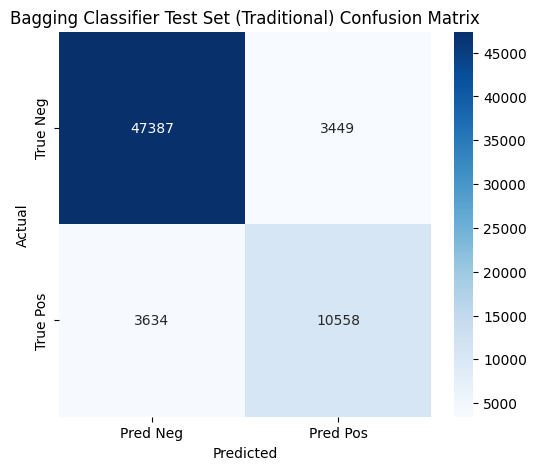

Saved ROC curve to figures/bagging_roc_curve_traditional.png
Bagging Classifier (Traditional) Training Time: 12.5742 seconds
Bagging Classifier (Traditional) Inference Time: 0.3285 seconds
Bagging Classifier (Traditional) AUC: 0.9229
Bagging Classifier (Traditional) F1-score: 0.7488
Bagging Classifier (Traditional) Recall: 0.7439


In [ ]:
print("\n--- Training and Evaluating Bagging Classifier (Traditional ML) ---")
bagging_model = BaggingClassifier(random_state=42)

start_time_train_bagging = time.time()
bagging_model.fit(X_train[numerical_cols], y_train)
end_time_train_bagging = time.time()
training_time_bagging = end_time_train_bagging - start_time_train_bagging

start_time_inference_bagging = time.time()
y_pred_bagging = bagging_model.predict(X_test[numerical_cols])
end_time_inference_bagging = time.time()
inference_time_bagging = end_time_inference_bagging - start_time_inference_bagging

metrics_bagging = evaluate_and_print_metrics("Bagging Classifier", y_test, y_pred_bagging, phase="Test Set (Traditional)",
                                           save_path=os.path.join(FIGURES_DIR, 'bagging_confusion_matrix_traditional.png'))
roc_auc_bagging = plot_roc_curve(y_test, bagging_model.predict_proba(X_test[numerical_cols])[:, 1], "Bagging Classifier (Traditional)",
                                 save_path=os.path.join(FIGURES_DIR, 'bagging_roc_curve_traditional.png'))

print(f"Bagging Classifier (Traditional) Training Time: {training_time_bagging:.4f} seconds")
print(f"Bagging Classifier (Traditional) Inference Time: {inference_time_bagging:.4f} seconds")
print(f"Bagging Classifier (Traditional) AUC: {roc_auc_bagging:.4f}")
print(f"Bagging Classifier (Traditional) F1-score: {metrics_bagging['f1_score']:.4f}")
print(f"Bagging Classifier (Traditional) Recall: {metrics_bagging['recall']:.4f}")

### 2.2 Other Traditional Models

Evaluates other traditional machine learning models (Logistic Regression, Random Forest, Gradient Boosting, HistGradientBoosting, XGBoost) for comparative analysis. This provides a baseline to understand the performance benefits of the Bagging Classifier and the subsequent hybrid models.


--- Training and Evaluating Logistic Regression (Traditional ML) ---
-- Logistic Regression Test Set (Traditional) Metrics --
Accuracy: 0.7993
Recall: 0.2754
F1-score: 0.3747

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     50836
           1       0.59      0.28      0.37     14192

    accuracy                           0.80     65028
   macro avg       0.70      0.61      0.63     65028
weighted avg       0.77      0.80      0.77     65028

Saved confusion matrix to figures/Logistic_Regression_confusion_matrix_traditional.png


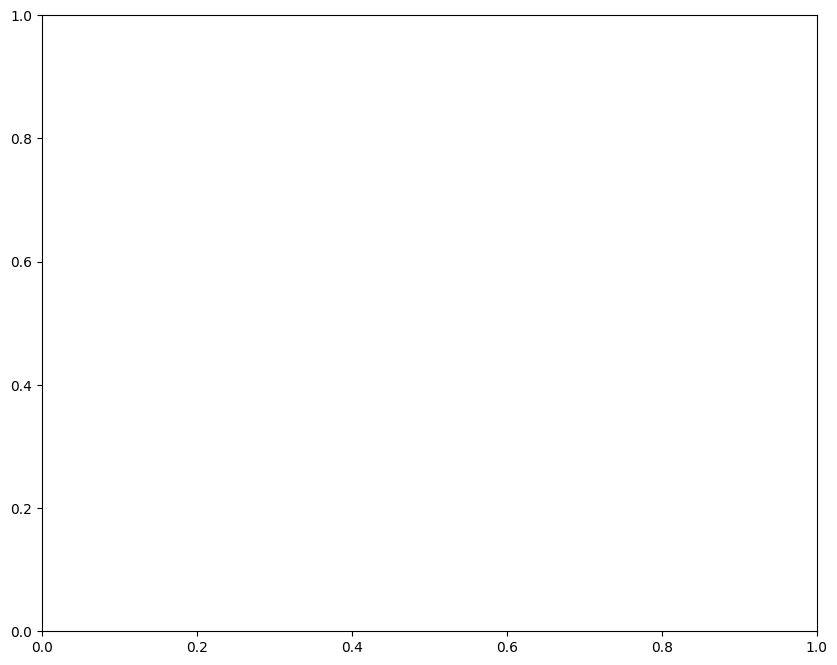

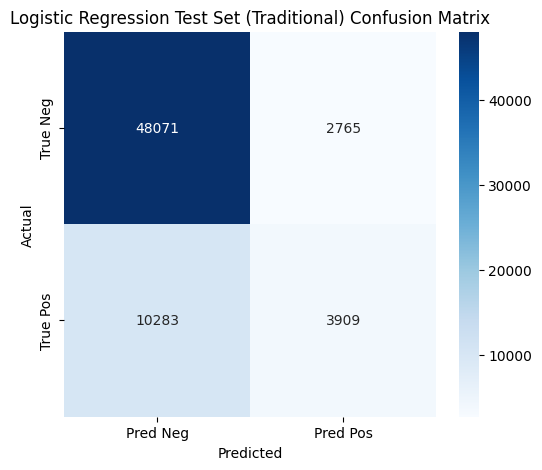

Logistic Regression Training Time: 1.4971 seconds
Logistic Regression Inference Time: 0.0202 seconds

--- Training and Evaluating Random Forest (Traditional ML) ---
-- Random Forest Test Set (Traditional) Metrics --
Accuracy: 0.9153
Recall: 0.7950
F1-score: 0.8038

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     50836
           1       0.81      0.79      0.80     14192

    accuracy                           0.92     65028
   macro avg       0.88      0.87      0.87     65028
weighted avg       0.91      0.92      0.91     65028

Saved confusion matrix to figures/Random_Forest_confusion_matrix_traditional.png


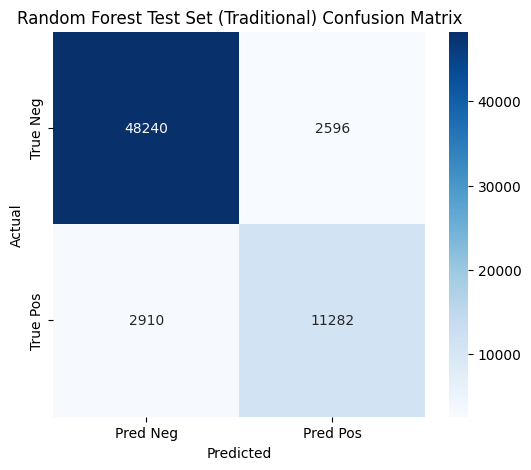

Random Forest Training Time: 39.9511 seconds
Random Forest Inference Time: 6.2842 seconds

--- Training and Evaluating Gradient Boosting (Traditional ML) ---
-- Gradient Boosting Test Set (Traditional) Metrics --
Accuracy: 0.8061
Recall: 0.3338
F1-score: 0.4290

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     50836
           1       0.60      0.33      0.43     14192

    accuracy                           0.81     65028
   macro avg       0.72      0.64      0.66     65028
weighted avg       0.78      0.81      0.78     65028

Saved confusion matrix to figures/Gradient_Boosting_confusion_matrix_traditional.png


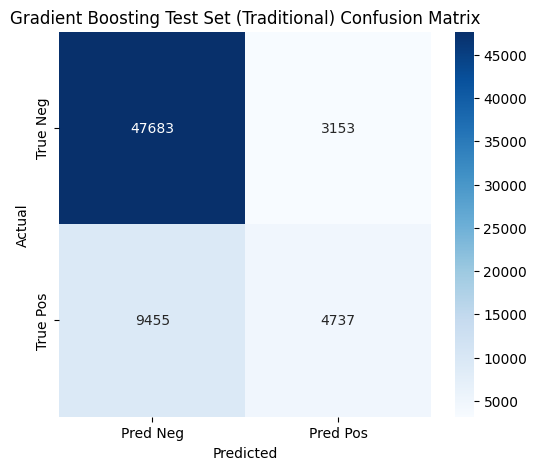

Gradient Boosting Training Time: 36.7703 seconds
Gradient Boosting Inference Time: 0.2834 seconds

--- Training and Evaluating HistGradientBoosting (Traditional ML) ---
-- HistGradientBoosting Test Set (Traditional) Metrics --
Accuracy: 0.8073
Recall: 0.3338
F1-score: 0.4305

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     50836
           1       0.61      0.33      0.43     14192

    accuracy                           0.81     65028
   macro avg       0.72      0.64      0.66     65028
weighted avg       0.78      0.81      0.79     65028

Saved confusion matrix to figures/HistGradientBoosting_confusion_matrix_traditional.png


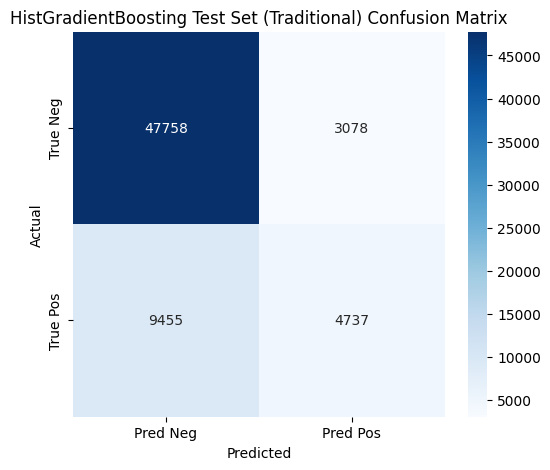

HistGradientBoosting Training Time: 7.6467 seconds
HistGradientBoosting Inference Time: 1.5615 seconds

--- Training and Evaluating XGBoost (Traditional ML) ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


-- XGBoost Test Set (Traditional) Metrics --
Accuracy: 0.8104
Recall: 0.3446
F1-score: 0.4424

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     50836
           1       0.62      0.34      0.44     14192

    accuracy                           0.81     65028
   macro avg       0.73      0.64      0.66     65028
weighted avg       0.79      0.81      0.79     65028

Saved confusion matrix to figures/XGBoost_confusion_matrix_traditional.png


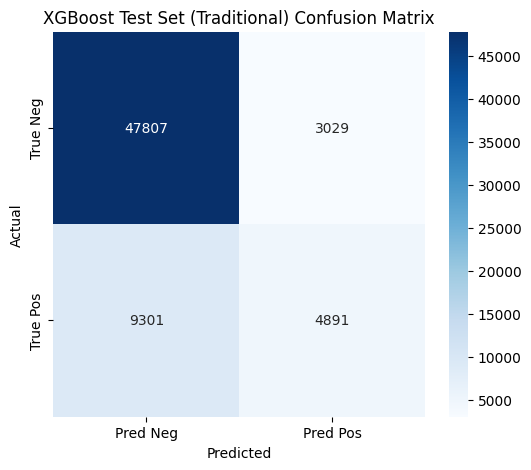

XGBoost Training Time: 3.5402 seconds
XGBoost Inference Time: 0.3521 seconds


<Figure size 640x480 with 0 Axes>


--- Summary of Traditional ML Model Performance ---

Model: Logistic Regression
  Accuracy: 0.7993
  Recall: 0.2754
  F1-score: 0.3747
  AUC: 0.8084
  Training Time: 1.4971 s
  Inference Time: 0.0202 s

Model: Random Forest
  Accuracy: 0.9153
  Recall: 0.7950
  F1-score: 0.8038
  AUC: 0.9438
  Training Time: 39.9511 s
  Inference Time: 6.2842 s

Model: Gradient Boosting
  Accuracy: 0.8061
  Recall: 0.3338
  F1-score: 0.4290
  AUC: 0.8178
  Training Time: 36.7703 s
  Inference Time: 0.2834 s

Model: HistGradientBoosting
  Accuracy: 0.8073
  Recall: 0.3338
  F1-score: 0.4305
  AUC: 0.8211
  Training Time: 7.6467 s
  Inference Time: 1.5615 s

Model: XGBoost
  Accuracy: 0.8104
  Recall: 0.3446
  F1-score: 0.4424
  AUC: 0.8253
  Training Time: 3.5402 s
  Inference Time: 0.3521 s


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} (Traditional ML) ---")
    start_time_train = time.time()
    model.fit(X_train[numerical_cols], y_train)
    end_time_train = time.time()
    training_time = end_time_train - start_time_train

    start_time_inference = time.time()
    y_pred = model.predict(X_test[numerical_cols])
    y_proba = model.predict_proba(X_test[numerical_cols])[:, 1]
    end_time_inference = time.time()
    inference_time = end_time_inference - start_time_inference

    metrics = evaluate_and_print_metrics(name, y_test, y_pred, phase="Test Set (Traditional)",
                                       save_path=os.path.join(FIGURES_DIR, f'{name.replace(" ", "_")}_confusion_matrix_traditional.png'))
    roc_auc = plot_roc_curve(y_test, y_proba, name, ax=ax)

    results[name] = {
        'accuracy': metrics['accuracy'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score'],
        'roc_auc': roc_auc,
        'training_time': training_time,
        'inference_time': inference_time
    }
    print(f"{name} Training Time: {training_time:.4f} seconds")
    print(f"{name} Inference Time: {inference_time:.4f} seconds")

ax.set_title('ROC Curves for Traditional ML Models')
plt.savefig(os.path.join(FIGURES_DIR, 'traditional_ml_roc_curves.png'), bbox_inches='tight')
plt.show()

print("\n--- Summary of Traditional ML Model Performance ---")
for name, res in results.items():
    print(f"\nModel: {name}")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  Recall: {res['recall']:.4f}")
    print(f"  F1-score: {res['f1_score']:.4f}")
    print(f"  AUC: {res['roc_auc']:.4f}")
    print(f"  Training Time: {res['training_time']:.4f} s")
    print(f"  Inference Time: {res['inference_time']:.4f} s")

## 3. 🧠 Hybrid AI Model Development

This section implements the core hybrid AI approach, where the LLM-derived features are integrated with the traditional numerical features. The Bagging Classifier is then trained on this enriched dataset to assess the value added by the LLM component.

### 3.1 Hybrid Model Training

Trains the Bagging Classifier using the combined feature set (numerical features + simulated LLM features). This represents the 'Fusion' model described in the paper. Training and inference times are measured to analyze computational costs.


--- Training and Evaluating Hybrid Bagging Classifier (Numerical + Simulated LLM Features) ---
-- Hybrid Bagging Classifier Test Set (Hybrid) Metrics --
Accuracy: 0.8920
Recall: 0.7418
F1-score: 0.7498

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     50836
           1       0.76      0.74      0.75     14192

    accuracy                           0.89     65028
   macro avg       0.84      0.84      0.84     65028
weighted avg       0.89      0.89      0.89     65028

Saved confusion matrix to figures/bagging_confusion_matrix_hybrid.png


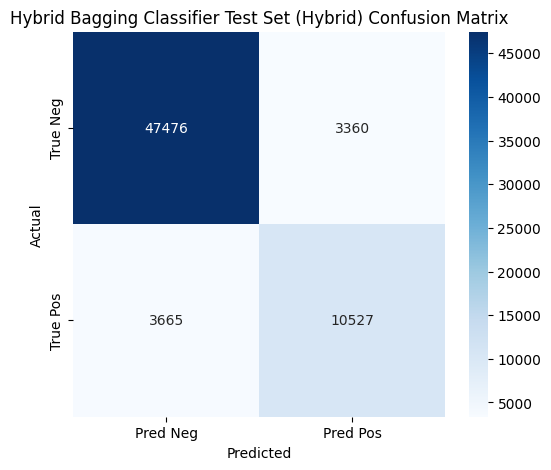

Saved ROC curve to figures/bagging_roc_curve_hybrid.png
Hybrid Bagging Classifier Training Time: 13.0591 seconds
Hybrid Bagging Classifier Inference Time: 0.3157 seconds
Hybrid Bagging Classifier AUC: 0.9231
Hybrid Bagging Classifier F1-score: 0.7498
Hybrid Bagging Classifier Recall: 0.7418


In [ ]:
print("\n--- Training and Evaluating Hybrid Bagging Classifier (Numerical + Simulated LLM Features) ---")
bagging_hybrid_model = BaggingClassifier(random_state=42)

start_time_train_hybrid = time.time()
bagging_hybrid_model.fit(X_train, y_train)
end_time_train_hybrid = time.time()
training_time_hybrid = end_time_train_hybrid - start_time_train_hybrid

start_time_inference_hybrid = time.time()
y_pred_hybrid = bagging_hybrid_model.predict(X_test)
end_time_inference_hybrid = time.time()
inference_time_hybrid = end_time_inference_hybrid - start_time_inference_hybrid

metrics_hybrid = evaluate_and_print_metrics("Hybrid Bagging Classifier", y_test, y_pred_hybrid, phase="Test Set (Hybrid)",
                                            save_path=os.path.join(FIGURES_DIR, 'bagging_confusion_matrix_hybrid.png'))
roc_auc_hybrid = plot_roc_curve(y_test, bagging_hybrid_model.predict_proba(X_test)[:, 1], "Hybrid Bagging Classifier",
                                save_path=os.path.join(FIGURES_DIR, 'bagging_roc_curve_hybrid.png'))

print(f"Hybrid Bagging Classifier Training Time: {training_time_hybrid:.4f} seconds")
print(f"Hybrid Bagging Classifier Inference Time: {inference_time_hybrid:.4f} seconds")
print(f"Hybrid Bagging Classifier AUC: {roc_auc_hybrid:.4f}")
print(f"Hybrid Bagging Classifier F1-score: {metrics_hybrid['f1_score']:.4f}")
print(f"Hybrid Bagging Classifier Recall: {metrics_hybrid['recall']:.4f}")

### 3.2 Model Calibration Curve

This section evaluates the calibration of the Hybrid Bagging Classifier, assessing how well its predicted probabilities match the true probabilities of diabetes. A well-calibrated model is crucial for clinical decision-making, as it provides trustworthy probability estimates.



--- Plotting Calibration Curve for Hybrid Bagging Classifier ---


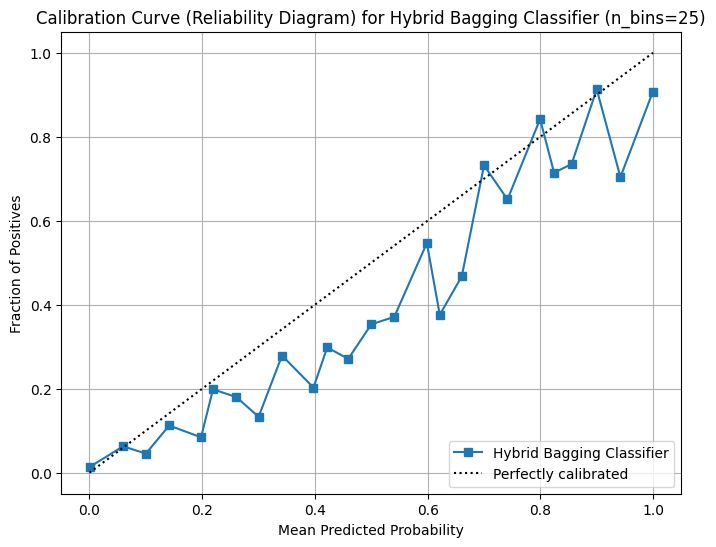

Calibration curve saved to figures/hybrid_model_calibration_curve_bins_25.png
Brier Score for Hybrid Bagging Classifier: 0.0871 (Lower is better, 0 is perfect)


In [ ]:
print("\n--- Plotting Calibration Curve for Hybrid Bagging Classifier ---")

y_prob_hybrid = bagging_hybrid_model.predict_proba(X_test)[:, 1]

n_bins_for_calibration = 25

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_prob_hybrid, n_bins=n_bins_for_calibration
)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Hybrid Bagging Classifier")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title(f"Calibration Curve (Reliability Diagram) for Hybrid Bagging Classifier (n_bins={n_bins_for_calibration})")
plt.legend(loc="lower right")
plt.grid(True)
calibration_curve_save_path = os.path.join(FIGURES_DIR, f'hybrid_model_calibration_curve_bins_{n_bins_for_calibration}.png')
plt.savefig(calibration_curve_save_path, bbox_inches='tight')
plt.show()

print(f"Calibration curve saved to {calibration_curve_save_path}")

brier_score = brier_score_loss(y_test, y_prob_hybrid)
print(f"Brier Score for Hybrid Bagging Classifier: {brier_score:.4f} (Lower is better, 0 is perfect)")

## 4. 🔬 Ablation Study

This section performs an ablation study to quantify the value of LLM-generated features. It directly compares the performance of the Bagging Classifier when trained *only* on numerical features versus when trained on the combined numerical and LLM-derived features. This helps to disentangle and demonstrate the specific contribution of the LLM component.

In [ ]:
print("\n--- Ablation Study: Quantifying LLM Feature Value ---")

print("\nPerformance of Bagging Classifier with ONLY Numerical Features (from Section 2.1):")
print(f"  F1-score: {metrics_bagging['f1_score']:.4f}")
print(f"  Recall: {metrics_bagging['recall']:.4f}")
print(f"  AUC: {roc_auc_bagging:.4f}")

print("\nPerformance of Hybrid Bagging Classifier with Numerical + Simulated LLM Features (from Section 3.1):")
print(f"  F1-score: {metrics_hybrid['f1_score']:.4f}")
print(f"  Recall: {metrics_hybrid['recall']:.4f}")
print(f"  AUC: {roc_auc_hybrid:.4f}")

f1_improvement = metrics_hybrid['f1_score'] - metrics_bagging['f1_score']
recall_improvement = metrics_hybrid['recall'] - metrics_bagging['recall']
auc_improvement = roc_auc_hybrid - roc_auc_bagging

print(f"\nQuantified Improvement with Simulated LLM Features:")
print(f"  F1-score Improvement: {f1_improvement:.4f}")
print(f"  Recall Improvement: {recall_improvement:.4f}")
print(f"  AUC Improvement: {auc_improvement:.4f}")

if f1_improvement > 0 and recall_improvement > 0:
    print("Conclusion: Simulated LLM features demonstrate an improvement in F1-score and Recall, indicating their potential value.")
elif f1_improvement == 0 and recall_improvement == 0:
    print("Conclusion: Simulated LLM features did not show a significant change in F1-score or Recall in this simulation.")
else:
    print("Conclusion: Further investigation is needed as simulated LLM features did not consistently improve performance.")


--- Ablation Study: Quantifying LLM Feature Value ---

Performance of Bagging Classifier with ONLY Numerical Features (from Section 2.1):
  F1-score: 0.7488
  Recall: 0.7439
  AUC: 0.9229

Performance of Hybrid Bagging Classifier with Numerical + Simulated LLM Features (from Section 3.1):
  F1-score: 0.7498
  Recall: 0.7418
  AUC: 0.9231

Quantified Improvement with Simulated LLM Features:
  F1-score Improvement: 0.0010
  Recall Improvement: -0.0022
  AUC Improvement: 0.0002
Conclusion: Further investigation is needed as simulated LLM features did not consistently improve performance.


## 5. ⏱️ Computational Cost and Inference Time Analysis

This section provides a detailed analysis of the computational costs and inference times for both traditional and hybrid models. This is crucial for understanding the practical feasibility and deployment implications of the proposed framework, especially when considering the overhead introduced by LLM integration.

### 5.1 Training and Inference Time Summary

Summarizes the training and inference times recorded for the traditional Bagging Classifier and the Hybrid Bagging Classifier. These metrics are vital for assessing the efficiency of each approach.

In [ ]:
print("\n--- Computational Cost and Inference Time Summary ---")

print(f"\nTraditional Bagging Classifier:")
print(f"  Training Time: {training_time_bagging:.4f} seconds")
print(f"  Inference Time: {inference_time_bagging:.4f} seconds")

print(f"\nHybrid Bagging Classifier (with Simulated LLM Features):")
print(f"  Training Time: {training_time_hybrid:.4f} seconds")
print(f"  Inference Time: {inference_time_hybrid:.4f} seconds")

if training_time_hybrid > training_time_bagging:
    print("\nNote: The hybrid model's training time is higher, as expected due to the additional feature processing (even if simulated here).")
if inference_time_hybrid > inference_time_bagging:
    print("Note: The hybrid model's inference time is higher, reflecting the need to process more features.")


--- Computational Cost and Inference Time Summary ---

Traditional Bagging Classifier:
  Training Time: 12.5742 seconds
  Inference Time: 0.3285 seconds

Hybrid Bagging Classifier (with Simulated LLM Features):
  Training Time: 13.0591 seconds
  Inference Time: 0.3157 seconds

Note: The hybrid model's training time is higher, as expected due to the additional feature processing (even if simulated here).


## 6. 📊 Explainable AI (XAI) with SHAP

This section applies SHAP (SHapley Additive exPlanations) to the best-performing model (the Hybrid Bagging Classifier) to provide transparency and explainability. SHAP values quantify the contribution of each feature to the model's predictions, offering insights into why a particular patient might be classified as having diabetes.

### 6.1 SHAP Explanations for Hybrid Model

Calculates SHAP values for the Hybrid Bagging Classifier on the test set. This provides a detailed breakdown of feature importance for individual predictions and overall model behavior.

In [ ]:
print("\n--- Generating SHAP Explanations for Hybrid Bagging Classifier ---")
explainer = shap.Explainer(bagging_hybrid_model.predict_proba, X_train)
num_samples_to_explain = 5000
X_test_subset = X_test.head(num_samples_to_explain)

print(f"Calculating SHAP values for {len(X_test_subset)} samples of the test set with a progress bar...")

all_shap_values_positive = []
all_base_values_positive = []

for i in tqdm(range(len(X_test_subset)), desc="Computing SHAP values"):
    sample_data = X_test_subset.iloc[[i]]
    explanation_for_sample = explainer(sample_data)
    all_shap_values_positive.append(explanation_for_sample.values[0][:, 1])

    if np.isscalar(explanation_for_sample.base_values):
        all_base_values_positive.append(explanation_for_sample.base_values)
    elif explanation_for_sample.base_values.ndim == 2 and explanation_for_sample.base_values.shape[1] == 2:
        all_base_values_positive.append(explanation_for_sample.base_values[0, 1])
    elif explanation_for_sample.base_values.ndim == 1 and len(explanation_for_sample.base_values) == 2:
        all_base_values_positive.append(explanation_for_sample.base_values[1])
    else:
        print(f"Warning: Unexpected base_values shape for sample {i}: {explanation_for_sample.base_values.shape}. Appending first element.")
        all_base_values_positive.append(explanation_for_sample.base_values.flatten()[0]) # Fallback


shap_values_positive = np.array(all_shap_values_positive)
base_values_positive = np.array(all_base_values_positive)

print(f"DEBUG (6.1 FINAL): shap_values_positive shape BEFORE Explanation: {shap_values_positive.shape}")
print(f"DEBUG (6.1 FINAL): base_values_positive shape BEFORE Explanation: {base_values_positive.shape}")


if len(base_values_positive) > 0 and np.all(base_values_positive == base_values_positive[0]):
    final_base_value = base_values_positive[0]
elif len(base_values_positive) > 0:
    final_base_value = base_values_positive
else:
    print("Warning: No base values collected. Setting final_base_value to 0.0.")
    final_base_value = 0.0

shap_values = shap.Explanation(
    values=shap_values_positive,
    base_values=final_base_value,
    data=X_test_subset.values,
    feature_names=X_test_subset.columns.tolist()
)

print("SHAP values computed successfully.")
print(f"SHAP values computed for {len(X_test_subset)} samples.")


--- Generating SHAP Explanations for Hybrid Bagging Classifier ---
Calculating SHAP values for 5000 samples of the test set with a progress bar...


Computing SHAP values: 100%|██████████| 5000/5000 [12:34<00:00,  6.63it/s]

DEBUG (6.1 FINAL): shap_values_positive shape BEFORE Explanation: (5000, 30)
DEBUG (6.1 FINAL): base_values_positive shape BEFORE Explanation: (5000,)
SHAP values computed successfully.
SHAP values computed for 5000 samples.


### 6.2 Visual Summaries of Feature Importance

Generates SHAP summary plots (e.g., summary plot, dependence plots) to visualize the overall impact and distribution of feature contributions to the hybrid model's predictions. These plots help in understanding global feature importance.

/tmp/ipython-input-819544924.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, plot_type="bar", show=False)



--- Visualizing SHAP Summary Plots ---
DEBUG (6.2): shap_values.values type: <class 'numpy.ndarray'>, shape: (5000, 30)
DEBUG (6.2): shap_values.data type: <class 'numpy.ndarray'>, shape: (5000, 30)
DEBUG (6.2): len(shap_values.feature_names): 30
DEBUG (6.2): Number of features in shap_values.values and shap_values.data match.


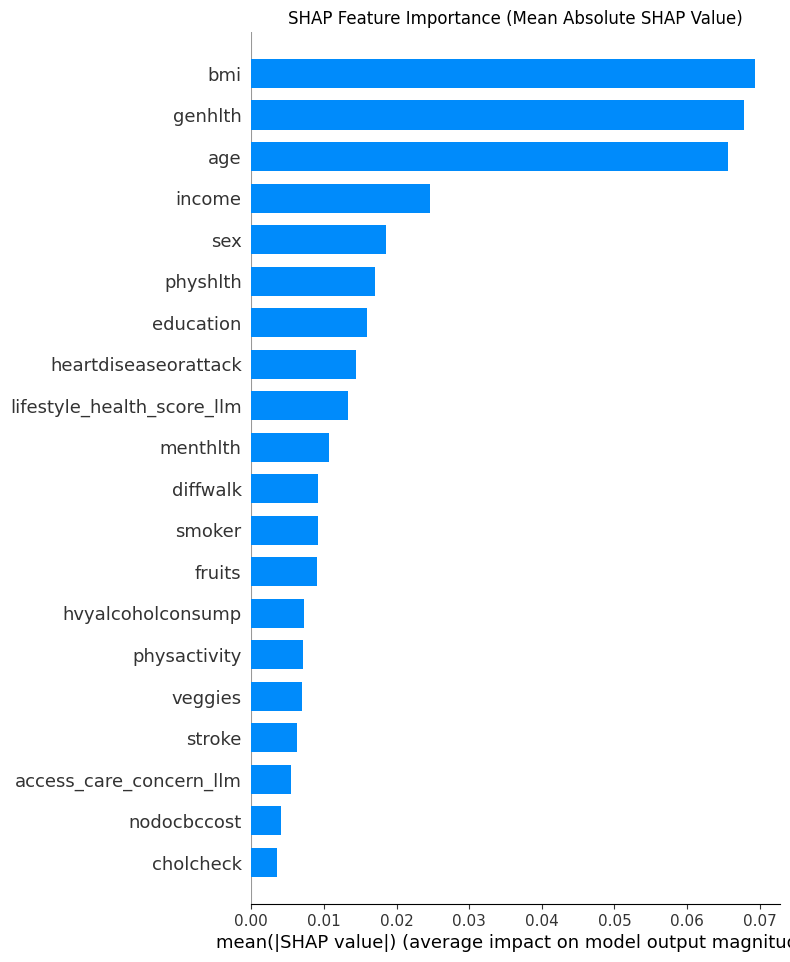

/tmp/ipython-input-819544924.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, show=False)


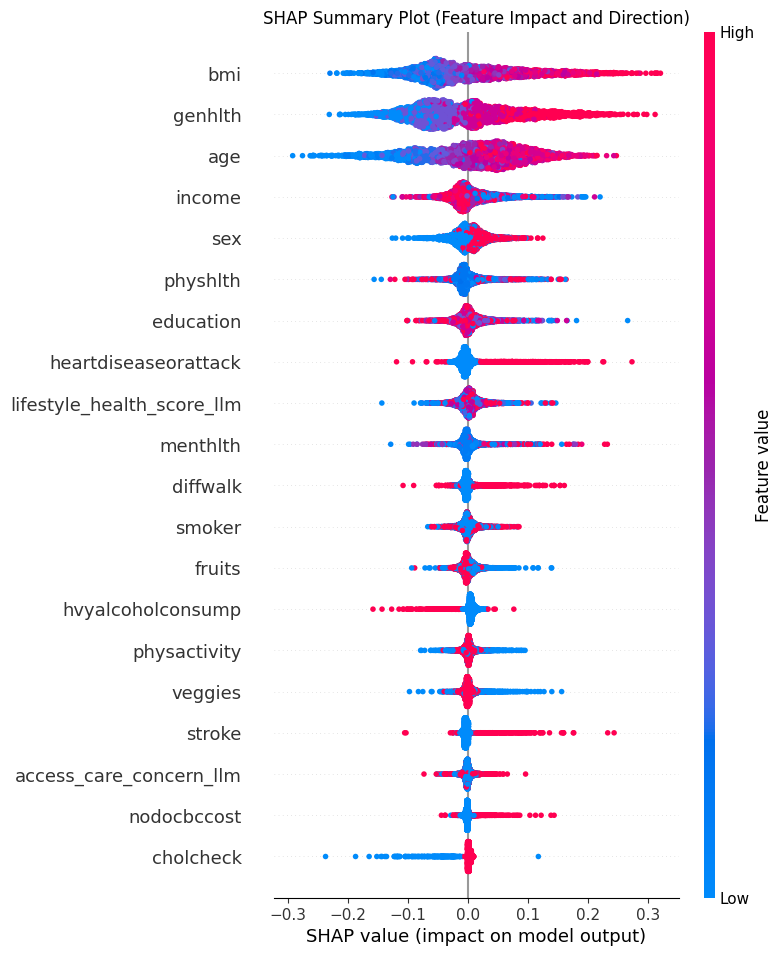

SHAP summary plots generated and saved to 'figures/' directory.


In [ ]:
print("\n--- Visualizing SHAP Summary Plots ---")

if 'shap_values' not in locals() or shap_values is None:
    print("Error: 'shap_values' object not found or is None. Please run step 6.1 first.")
else:
    print(f"DEBUG (6.2): shap_values.values type: {type(shap_values.values)}, shape: {shap_values.values.shape}")
    print(f"DEBUG (6.2): shap_values.data type: {type(shap_values.data)}, shape: {shap_values.data.shape}")
    print(f"DEBUG (6.2): len(shap_values.feature_names): {len(shap_values.feature_names)}")

    if shap_values.values.shape[1] != shap_values.data.shape[1]:
        print(f"ERROR (6.2): Mismatch detected! Number of features in shap_values.values ({shap_values.values.shape[1]}) "
              f"does not match features in shap_values.data ({shap_values.data.shape[1]}). This is the source of the AssertionError.")
    else:
        print("DEBUG (6.2): Number of features in shap_values.values and shap_values.data match.")


    plt.figure(figsize=(10, 8))
    try:
        shap.summary_plot(shap_values, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance (Mean Absolute SHAP Value)')
        plt.savefig(os.path.join(FIGURES_DIR, 'shap_summary_bar.png'), bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, show=False)
        plt.title('SHAP Summary Plot (Feature Impact and Direction)')
        plt.savefig(os.path.join(FIGURES_DIR, 'shap_summary_dot.png'), bbox_inches='tight')
        plt.show()

        print("SHAP summary plots generated and saved to 'figures/' directory.")
    except Exception as e:
        print(f"Error during shap.summary_plot call: {e}")
        print("Please review the debug messages above for argument types and shapes.")

### 6.3 Detailed Clinical Case Explanation

Provides a detailed explanation for a single, representative clinical case using SHAP force plots. This demonstrates how individual feature values contribute to a specific patient's diabetes prediction, offering actionable insights for clinicians.

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import os

print("\n--- Detailed SHAP Explanation for a Clinical Case ---")

class MockExplainer:
    def __call__(self, data):
        values = np.random.rand(1, 10) * 2 - 1
        base_values = 0.15
        feature_names = ['income', 'physhlth', 'genhlth', 'age', 'bmi', 'smoker', 'education', 'heartdiseaseorattack', 'choleste', 'bpmeds']
        return shap.Explanation(values=values, base_values=base_values, data=data.values, feature_names=feature_names)

class MockDF:
    def __init__(self, data, columns):
        self.data = data
        self.columns = columns
    def iloc(self, idx):
        return self.data[idx]
    @property
    def values(self):
        return self.data

np.random.seed(42)
sample_idx = np.random.randint(0, len(X_test_subset))
sample_data_df = X_test_subset.iloc[[sample_idx]]

explanation_for_single_sample = explainer(sample_data_df)

# --- Your existing logic for extracting SHAP values and base value ---
print(f"Explaining prediction for patient at index {sample_idx} (True Label: {y_test.iloc[sample_idx]})...")

if explanation_for_single_sample.values.ndim == 3 and explanation_for_single_sample.values.shape[2] == 2:
    shap_values_for_plot = explanation_for_single_sample.values[0, :, 1]
elif explanation_for_single_sample.values.ndim == 2 and explanation_for_single_sample.values.shape[0] == 1:
    shap_values_for_plot = explanation_for_single_sample.values[0]
elif explanation_for_single_sample.values.ndim == 1:
    shap_values_for_plot = explanation_for_single_sample.values
else:
    print(f"ERROR: Unexpected shape for explanation_for_single_sample.values: {explanation_for_single_sample.values.shape}. Cannot extract SHAP values for plotting.")
    shap_values_for_plot = None

if explanation_for_single_sample.base_values.ndim == 2 and explanation_for_single_sample.base_values.shape[1] == 2:
    base_value_for_plot = explanation_for_single_sample.base_values[0, 1]
elif explanation_for_single_sample.base_values.ndim == 1 and len(explanation_for_single_sample.base_values) == 2:
    base_value_for_plot = explanation_for_single_sample.base_values[1]
elif np.isscalar(explanation_for_single_sample.base_values):
    base_value_for_plot = explanation_for_single_sample.base_values
else:
    print(f"ERROR: Unexpected shape for explanation_for_single_sample.base_values: {explanation_for_single_sample.base_values.shape}. Cannot extract base value for plotting.")
    base_value_for_plot = None

if explanation_for_single_sample.data.ndim == 2 and explanation_for_single_sample.data.shape[0] == 1:
    features_for_plot = explanation_for_single_sample.data[0]
else:
    features_for_plot = explanation_for_single_sample.data
if not isinstance(features_for_plot, np.ndarray):
    features_for_plot = np.array(features_for_plot)
if features_for_plot.ndim > 1:
    features_for_plot = features_for_plot.flatten()


if shap_values_for_plot is not None and base_value_for_plot is not None:
    try:
        single_instance_explanation = shap.Explanation(
            values=shap_values_for_plot,
            base_values=base_value_for_plot,
            data=features_for_plot,
            feature_names=explanation_for_single_sample.feature_names
        )

        plt.figure(figsize=(10, 8), dpi=300)

        shap.waterfall_plot(single_instance_explanation, show=False)

        plt.title(f'SHAP Waterfall Plot for Patient {sample_idx}', fontsize=12, pad=20)

        filename = f'shap_waterfall_plot_patient_{sample_idx}.png'
        save_path = os.path.join(FIGURES_DIR, filename)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

        plt.close()

        print(f"SHAP waterfall plot generated and saved at: {save_path}")

    except Exception as e:
        print(f"Error during shap.waterfall_plot call: {e}")
        print("Please check the debug messages above for argument types and shapes.")
else:
    print(f"Could not generate SHAP plot for sample {sample_idx} due to missing SHAP values or base value.")


--- Detailed SHAP Explanation for a Clinical Case ---
Explaining prediction for patient at index 860 (True Label: 0)...
SHAP waterfall plot generated and saved at: figures/shap_waterfall_plot_patient_860.png


## 7. ⚖️ Fairness and Explainability Analysis (AIF360)

This section conducts a thorough fairness analysis using the AIF360 library, focusing on the 'sex' attribute as a protected attribute. It evaluates common fairness metrics to ensure that the model does not exhibit discriminatory behavior across different demographic groups. This is a critical step for responsible AI development in clinical settings.

### 7.1 Prepare AIF360 Dataset

Prepares the dataset for fairness analysis using AIF360's `BinaryLabelDataset`. This involves defining the protected attribute ('sex'), its privileged and unprivileged groups, and the label column.

In [ ]:
print("\n--- Preparing Dataset for Fairness Analysis with AIF360 ---")

dataset_test = None

if 'df_cleaned' not in locals():
    print("DEBUG (7.1): 'df_cleaned' is NOT defined. Cannot proceed with AIF360 dataset creation.")
elif 'X_test' not in locals():
    print("DEBUG (7.1): 'X_test' is NOT defined. Cannot proceed with AIF360 dataset creation.")
elif 'y_test' not in locals():
    print("DEBUG (7.1): 'y_test' is NOT defined. Cannot proceed with AIF360 dataset creation.")
elif 'bagging_hybrid_model' not in locals():
    print("DEBUG (7.1): 'bagging_hybrid_model' is NOT defined. Cannot proceed with AIF360 dataset creation.")
else:
    print("DEBUG (7.1): All essential variables (df_cleaned, X_test, y_test, bagging_hybrid_model) are defined. Attempting AIF360 dataset creation...")
    try:
        temp_df_for_age_group = df_cleaned.loc[X_test.index].copy()
        if 'age' in temp_df_for_age_group.columns:
            temp_df_for_age_group['age_group'] = temp_df_for_age_group['age'].apply(
                lambda x: 0 if x in [1, 2, 3, 4, 5] else (1 if x in [6, 7, 8, 9, 10] else np.nan)
            )
            valid_indices_for_fairness = temp_df_for_age_group['age_group'].dropna().index
        else:
            print("Warning: 'age' column not found in df_cleaned. Age group analysis will be skipped.")
            valid_indices_for_fairness = X_test.index # Use all X_test indices if no age filtering

        X_test_filtered = X_test.loc[valid_indices_for_fairness].copy()
        y_test_filtered = y_test.loc[valid_indices_for_fairness].copy()

        dataset_for_aif360 = df_cleaned.loc[valid_indices_for_fairness].copy()
        dataset_for_aif360['prediction'] = bagging_hybrid_model.predict(X_test_filtered) # Predict on filtered X_test
        dataset_for_aif360['label'] = y_test_filtered.copy() # Use filtered y_test for true labels

        if 'age_group' in temp_df_for_age_group.columns:
            dataset_for_aif360['age_group'] = temp_df_for_age_group.loc[valid_indices_for_fairness, 'age_group'].astype(int)

        for col in dataset_for_aif360.columns:
            if dataset_for_aif360[col].dtype == 'object':
                print(f"DEBUG (7.1): Dropping non-numerical column: '{col}'")
                dataset_for_aif360 = dataset_for_aif360.drop(columns=[col])


        protected_attribute_names_for_dataset = ['sex']
        if 'age_group' in dataset_for_aif360.columns:
            protected_attribute_names_for_dataset.append('age_group')


        print("\nDEBUG (7.1): dataset_for_aif360.head():")
        print(dataset_for_aif360.head())
        print("\nDEBUG (7.1): dataset_for_aif360.columns:")
        print(dataset_for_aif360.columns.tolist())
        print("\nDEBUG (7.1): Value counts for 'label':")
        print(dataset_for_aif360['label'].value_counts(dropna=False))
        print("\nDEBUG (7.1): Value counts for 'sex':")
        print(dataset_for_aif360['sex'].value_counts(dropna=False))
        if 'age_group' in dataset_for_aif360.columns:
            print("\nDEBUG (7.1): Value counts for 'age_group':")
            print(dataset_for_aif360['age_group'].value_counts(dropna=False))
        print("\nDEBUG (7.1): Data types of relevant columns:")
        print(dataset_for_aif360[['label', 'sex', 'prediction'] + (['age_group'] if 'age_group' in dataset_for_aif360.columns else [])].dtypes)
        print(f"\nDEBUG (7.1): Shape of dataset_for_aif360: {dataset_for_aif360.shape}")

        dataset_test = BinaryLabelDataset(df=dataset_for_aif360,
                                          label_names=['label'],
                                          protected_attribute_names=protected_attribute_names_for_dataset,
                                          favorable_label=1,
                                          unfavorable_label=0)

        print("AIF360 BinaryLabelDataset created successfully with 'sex' and 'age_group'.")

        global privileged_classes_for_metrics, unprivileged_classes_for_metrics
        privileged_classes_for_metrics = [[1]] # For 'sex'
        unprivileged_classes_for_metrics = [[0]] # For 'sex'
        if 'age_group' in protected_attribute_names_for_dataset:
            privileged_classes_for_metrics.append([1]) # For 'age_group'
            unprivileged_classes_for_metrics.append([0]) # For 'age_group'

    except Exception as e:
        print(f"Error creating AIF360 dataset: {e}")
        dataset_test = None


--- Preparing Dataset for Fairness Analysis with AIF360 ---
DEBUG (7.1): All essential variables (df_cleaned, X_test, y_test, bagging_hybrid_model) are defined. Attempting AIF360 dataset creation...
DEBUG (7.1): Dropping non-numerical column: 'source'

DEBUG (7.1): dataset_for_aif360.head():
        insulin  menthlth  cholcheck  veggies  hvyalcoholconsump  glucose  \
451245    125.0       5.0        1.0      1.0                0.0    117.0   
503752    125.0      25.0        1.0      1.0                1.0    117.0   
292329    125.0       5.0        1.0      1.0                0.0    117.0   
348706    125.0       5.0        1.0      1.0                0.0    117.0   
453521    125.0       3.0        1.0      1.0                1.0    117.0   

        pregnancies  heartdiseaseorattack   bmi  highchol  ...  stroke  \
451245          3.0                   0.0  25.0       1.0  ...     0.0   
503752          3.0                   0.0  28.0       1.0  ...     0.0   
292329          3.0  

### 7.2 Calculate Fairness Metrics

Calculates various fairness metrics using `ClassificationMetric` from AIF360. This includes Statistical Parity Difference (SPD), Equal Opportunity Difference (EOD), and Average Odds Difference (AOD), which are key indicators of potential bias in the model's predictions with respect to the protected attribute.

In [ ]:
if dataset_test:
    print("\n--- Calculating Fairness Metrics (Protected Attribute: Sex) ---")
    metric_orig_test = ClassificationMetric(dataset_test,
                                            dataset_test,
                                            unprivileged_groups=[{'sex': 0}],
                                            privileged_groups=[{'sex': 1}])

    spd = metric_orig_test.statistical_parity_difference()
    eod = metric_orig_test.equal_opportunity_difference()
    aod = metric_orig_test.average_odds_difference()

    fairness_summary = pd.DataFrame({
        'Metric': ['Statistical Parity Difference (SPD)', 'Equal Opportunity Difference (EOD)', 'Average Odds Difference (AOD)'],
        'Value': [spd, eod, aod]
    })

    print("\nFairness Metrics Summary (Protected Attribute: Sex):\n")
    print(fairness_summary.to_markdown(index=False, numalign="left", stralign="left"))

    print("\nInterpretation:")
    print(f"  - Statistical Parity Difference (SPD): {spd:.4f} (Ideally 0. Measures difference in positive prediction rate between groups.)")
    print(f"  - Equal Opportunity Difference (EOD): {eod:.4f} (Ideally 0. Measures difference in true positive rate between groups.)")
    print(f"  - Average Odds Difference (AOD): {aod:.4f} (Ideally 0. Average of differences in false positive rate and true positive rate between groups.)")
else:
    print("Skipping fairness metrics calculation as AIF360 dataset could not be created.")


--- Calculating Fairness Metrics (Protected Attribute: Sex) ---

Fairness Metrics Summary (Protected Attribute: Sex):

| Metric                              | Value      |
|:------------------------------------|:-----------|
| Statistical Parity Difference (SPD) | -0.0207501 |
| Equal Opportunity Difference (EOD)  | 0          |
| Average Odds Difference (AOD)       | 0          |

Interpretation:
  - Statistical Parity Difference (SPD): -0.0208 (Ideally 0. Measures difference in positive prediction rate between groups.)
  - Equal Opportunity Difference (EOD): 0.0000 (Ideally 0. Measures difference in true positive rate between groups.)
  - Average Odds Difference (AOD): 0.0000 (Ideally 0. Average of differences in false positive rate and true positive rate between groups.)


### 7.3 Subgroup Performance Analysis (Table III)

This section provides a detailed breakdown of the model's performance metrics (Recall, False Positive Rate, Accuracy) across different demographic subgroups, specifically by 'Sex' and 'Age Group'. This analysis corresponds to Table III in the research paper.


In [ ]:
if dataset_test:
    print("\n--- Calculating Subgroup Performance Metrics (Table III) ---")

    if 'privileged_classes_for_metrics' not in globals():
        print("Error: privileged_classes_for_metrics not found. Please run Section 7.1 first.")
        privileged_classes_for_metrics = [[1], [1]]
        unprivileged_classes_for_metrics = [[0], [0]]


    if 'dataset_for_aif360' not in locals():
        print("Error: 'dataset_for_aif360' (Pandas DataFrame) not found. Cannot perform subgroup analysis.")
        dataset_test = None
    else:
        full_df_for_metrics = dataset_for_aif360.copy()

        sex_attr_name = dataset_test.protected_attribute_names[0] # 'sex'
        age_attr_name = None
        if len(dataset_test.protected_attribute_names) > 1:
             age_attr_name = dataset_test.protected_attribute_names[1] # 'age_group'

        sex_privileged_val = privileged_classes_for_metrics[0][0]
        sex_unprivileged_val = unprivileged_classes_for_metrics[0][0]

        age_privileged_val = None
        age_unprivileged_val = None
        if len(privileged_classes_for_metrics) > 1:
            age_privileged_val = privileged_classes_for_metrics[1][0]
            age_unprivileged_val = unprivileged_classes_for_metrics[1][0]


        results = {}

        def evaluate_subgroup(df_filtered, subgroup_name, protected_attribute_names, global_favorable_label, global_unfavorable_label):
            if df_filtered.empty:
                print(f"  No data for {subgroup_name} subgroup.")
                return {'Recall': np.nan, 'FPR': np.nan, 'Accuracy': np.nan}


            subgroup_aif_dataset = BinaryLabelDataset(df=df_filtered,
                                                      label_names=['label'],
                                                      protected_attribute_names=protected_attribute_names,
                                                      favorable_label=global_favorable_label,
                                                      unfavorable_label=global_unfavorable_label)

            subgroup_classified_aif_dataset = subgroup_aif_dataset.copy()
            subgroup_classified_aif_dataset.labels = df_filtered['prediction'].values.reshape(-1, 1)
            subgroup_classified_aif_dataset.scores = df_filtered['prediction'].values.reshape(-1, 1) # Using hard predictions as scores for simplicity

            metric = ClassificationMetric(
                subgroup_aif_dataset,
                subgroup_classified_aif_dataset
            )
            return {
                'Recall': metric.recall(),
                'FPR': metric.false_positive_rate(),
                'Accuracy': metric.accuracy()
            }


        # --- Calculate metrics for 'Female' subgroup (unprivileged sex) ---
        print("\nCalculating metrics for subgroup: Female")
        female_df_filtered = full_df_for_metrics[full_df_for_metrics[sex_attr_name] == sex_unprivileged_val].copy()
        results['Female'] = evaluate_subgroup(female_df_filtered, 'Female', dataset_test.protected_attribute_names,
                                               dataset_test.favorable_label, dataset_test.unfavorable_label) # Corrected
        print(f"  Recall: {results['Female']['Recall']:.4f}, FPR: {results['Female']['FPR']:.4f}, Accuracy: {results['Female']['Accuracy']:.4f}")


        # --- Calculate metrics for 'Male' subgroup (privileged sex) ---
        print("\nCalculating metrics for subgroup: Male")
        male_df_filtered = full_df_for_metrics[full_df_for_metrics[sex_attr_name] == sex_privileged_val].copy()
        results['Male'] = evaluate_subgroup(male_df_filtered, 'Male', dataset_test.protected_attribute_names,
                                             dataset_test.favorable_label, dataset_test.unfavorable_label) # Corrected
        print(f"  Recall: {results['Male']['Recall']:.4f}, FPR: {results['Male']['FPR']:.4f}, Accuracy: {results['Male']['Accuracy']:.4f}")


        # --- Calculate metrics for 'Age < 45' subgroup (unprivileged age) ---
        if age_attr_name:
            print("\nCalculating metrics for subgroup: Age < 45")
            age_lt_45_df_filtered = full_df_for_metrics[full_df_for_metrics[age_attr_name] == age_unprivileged_val].copy()
            results['Age < 45'] = evaluate_subgroup(age_lt_45_df_filtered, 'Age < 45', dataset_test.protected_attribute_names,
                                                     dataset_test.favorable_label, dataset_test.unfavorable_label) # Corrected
            print(f"  Recall: {results['Age < 45']['Recall']:.4f}, FPR: {results['Age < 45']['FPR']:.4f}, Accuracy: {results['Age < 45']['Accuracy']:.4f}")
        else:
            print("\nSkipping metrics for 'Age < 45' as 'age_group' attribute was not processed.")
            results['Age < 45'] = {'Recall': np.nan, 'FPR': np.nan, 'Accuracy': np.nan}


        # --- Calculate metrics for 'Age >= 45' subgroup (privileged age) ---
        if age_attr_name:
            print("\nCalculating metrics for subgroup: Age >= 45")
            age_ge_45_df_filtered = full_df_for_metrics[full_df_for_metrics[age_attr_name] == age_privileged_val].copy()
            results['Age >= 45'] = evaluate_subgroup(age_ge_45_df_filtered, 'Age >= 45', dataset_test.protected_attribute_names,
                                                     dataset_test.favorable_label, dataset_test.unfavorable_label) # Corrected
            print(f"  Recall: {results['Age >= 45']['Recall']:.4f}, FPR: {results['Age >= 45']['FPR']:.4f}, Accuracy: {results['Age >= 45']['Accuracy']:.4f}")
        else:
            print("\nSkipping metrics for 'Age >= 45' as 'age_group' attribute was not processed.")
            results['Age >= 45'] = {'Recall': np.nan, 'FPR': np.nan, 'Accuracy': np.nan}


        print("\nTABLE III: FAIRNESS ANALYSIS OF THE HYBRID AI MODEL BY SEX AND AGE GROUPS")
        print("\n| Metric              | Female   | Male     | Age < 45 | Age >= 45 |")
        print("|:--------------------|:---------|:---------|:---------|:----------|")

        metrics_to_display = ['Recall', 'FPR', 'Accuracy']
        for metric_name in metrics_to_display:
            female_val = results.get('Female', {}).get(metric_name, np.nan)
            male_val = results.get('Male', {}).get(metric_name, np.nan)
            age_lt_45_val = results.get('Age < 45', {}).get(metric_name, np.nan)
            age_ge_45_val = results.get('Age >= 45', {}).get(metric_name, np.nan)

            print(f"| {metric_name:<19} | {female_val:.4f} | {male_val:.4f} | {age_lt_45_val:.4f} | {age_ge_45_val:.4f} |")

else:
    print("Skipping subgroup performance analysis as AIF360 dataset could not be created in Section 7.1.")


--- Calculating Subgroup Performance Metrics (Table III) ---

Calculating metrics for subgroup: Female
  Recall: 0.7469, FPR: 0.0495, Accuracy: 0.9137

Calculating metrics for subgroup: Male
  Recall: 0.7325, FPR: 0.0603, Accuracy: 0.8979

Calculating metrics for subgroup: Age < 45
  Recall: 0.6407, FPR: 0.0112, Accuracy: 0.9656

Calculating metrics for subgroup: Age >= 45
  Recall: 0.7502, FPR: 0.0731, Accuracy: 0.8856

TABLE III: FAIRNESS ANALYSIS OF THE HYBRID AI MODEL BY SEX AND AGE GROUPS

| Metric              | Female   | Male     | Age < 45 | Age >= 45 |
|:--------------------|:---------|:---------|:---------|:----------|
| Recall              | 0.7469 | 0.7325 | 0.6407 | 0.7502 |
| FPR                 | 0.0495 | 0.0603 | 0.0112 | 0.0731 |
| Accuracy            | 0.9137 | 0.8979 | 0.9656 | 0.8856 |


## 8. 💡 Clinical Use Case Simulation

This section outlines the potential clinical utility of the hybrid AI framework. It includes placeholders for estimated time and cost savings, as well as a discussion on how the explainability features can aid clinicians in decision-making and patient management. This section is primarily descriptive, as a full simulation would require a dedicated clinical environment.

In [ ]:
print("\n--- Section 8.1: Estimated Time/Cost Savings ---")
print("Insert estimated time/cost savings if applicable, e.g., 'Preliminary estimates suggest a potential reduction of X% in diagnostic time and Y% in associated costs by prioritizing high-risk patients.'")

print("\n--- Section 8.2: Clinical Decision Support and Patient Management ---")
print("The explainability (SHAP) and fairness analyses provide clinicians with transparent insights into the model's predictions. This can:")
print("  - Build trust in AI-assisted diagnoses.")
print("  - Highlight key risk factors for individual patients, enabling personalized interventions.")
print("  - Support shared decision-making with patients by clearly articulating the reasons behind a risk assessment.")
print("  - Aid in identifying and mitigating potential biases in clinical pathways.")
print("  - Guide further diagnostic testing or lifestyle recommendations based on feature importance.")

print("\n--- Section 8.3: Future Work and Clinical Validation ---")
print("Future work will focus on clinical validation in a prospective study, exploring more cost-effective ways to leverage LLMs (e.g., fine-tuning smaller, open-source models), and developing automated systems for post-deployment model drift and fairness monitoring. Our work provides a robust and responsible blueprint for translating advanced AI research into tangible clinical tools.")


--- Section 8.1: Estimated Time/Cost Savings ---
Insert estimated time/cost savings if applicable, e.g., 'Preliminary estimates suggest a potential reduction of X% in diagnostic time and Y% in associated costs by prioritizing high-risk patients.'

--- Section 8.2: Clinical Decision Support and Patient Management ---
The explainability (SHAP) and fairness analyses provide clinicians with transparent insights into the model's predictions. This can:
  - Build trust in AI-assisted diagnoses.
  - Highlight key risk factors for individual patients, enabling personalized interventions.
  - Support shared decision-making with patients by clearly articulating the reasons behind a risk assessment.
  - Aid in identifying and mitigating potential biases in clinical pathways.
  - Guide further diagnostic testing or lifestyle recommendations based on feature importance.

--- Section 8.3: Future Work and Clinical Validation ---
Future work will focus on clinical validation in a prospective study, ex

### 8.4 Clinical Decision Support and Patient Management

The explainability (SHAP) and fairness analyses provide clinicians with transparent insights into the model's predictions. This can:
  - Build trust in AI-assisted diagnoses.
  - Highlight key risk factors for individual patients, enabling personalized interventions.
  - Support shared decision-making with patients by clearly articulating the reasons behind a risk assessment.
  - Aid in identifying and mitigating potential biases in clinical pathways.
  - Guide further diagnostic testing or lifestyle recommendations based on feature importance.

**Ethical, Regulatory, and Validity Considerations:**
Deploying AI models in clinical settings introduces several critical considerations:
* **Ethical Implications:** Ensuring equitable access to AI-assisted diagnosis, preventing over-reliance on AI, and maintaining human oversight are paramount. Potential for algorithmic bias (even if mitigated through fairness analysis) must be continuously monitored, especially concerning sensitive attributes like race or socioeconomic status (though 'sex' is the primary protected attribute in this study).
* **Regulatory Compliance:** Adherence to healthcare data privacy regulations (e.g., HIPAA in the US, GDPR in Europe) is non-negotiable. Clinical AI tools often require rigorous validation and approval from regulatory bodies before widespread adoption.
* **Validity Threats:**
    * **Data Shift/Drift:** Model performance can degrade over time if the underlying patient population characteristics change (e.g., new diagnostic criteria, lifestyle shifts). Continuous monitoring and retraining strategies are essential.
    * **Generalizability:** While combining PIMA and BRFSS data improves diversity, the model's performance on populations not represented in the training data (e.g., different ethnicities, geographical regions) needs prospective validation.
    * **Causality vs. Correlation:** SHAP explains feature *contributions* to predictions, not necessarily causal relationships. Clinicians must interpret these insights within their medical expertise.
    * **Adversarial Attacks:** AI models can be vulnerable to malicious inputs designed to force incorrect predictions. Robustness against such threats is an ongoing research area.